In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

In [51]:
def plot_data(data):
    x_label = "t"
    y_label = "θr"
    plt.plot(data[x_label], data[y_label])
    plt.xlabel(x_label)
    plt.ylabel(y_label)

In [52]:
def get_largo(data):
    data_r = data["r"]
    return data_r.mean(), data_r.std() + 0.1

In [53]:
def format_pd(data):
    data = data.dropna()
    # Arranca en t = 0
    #print(data["t"].iloc[0])
    data["t"] = data["t"] - data["t"].iloc[0]
    # Selecciona la columna de interés
    data = data[data["t"] <=5]
    return data

In [54]:
import math

rm = 1
drm = 0.1

def error_propagation_tita_from_rm_L(L, dL):
    return math.sqrt((L / (drm**2 + L**2))**2 + (rm / (dL**2 + rm**2))**2)

def gen_dθr(L):
    return math.atan(rm/L) + error_propagation_tita_from_rm_L(L, 0.1)

def gen_dicc_with_deltas(dicc, data):
    #data is a pandas dataframe with columns t, x, y, r, tita
    dicc["dx"] = 0.1
    dicc["dy"] = 0.1
    dicc["dr"] = data["r"].std() + 0.1
    dicc["dt"] = 1/30
    L = data["r"].mean()
    dicc["dθr"] = gen_dθr(L)
    dicc["dθ0"] = dicc["dθr"]

def gen_dicc(data):
    dicc = {}
    dicc["drm"] = 0.1
    gen_dicc_with_deltas(dicc, data)
    return dicc

In [55]:
import numpy as np

def get_all_params(data):
    dicc = gen_dicc(data)

    # Incertidumbre en θ y t (suponiendo que los conoces o los calculas)
    sigma_theta = dicc["dθr"]  # Ejemplo de incertidumbre en ángulo
    sigma_t = dicc["dt"]  # Ejemplo de incertidumbre en tiempo

    def get_tita0(data):
        try:
            return data["θr"].iloc[0], sigma_theta  # Incluye la incertidumbre
        except KeyError:
            return data["θ"].iloc[0], sigma_theta

    def get_amplitud(data):
        try:
            theta_max = max(data["θr"])
            theta_min = min(data["θr"])
            amplitud = (theta_max - theta_min) / 2
            # Propagación de incertidumbre en la diferencia
            sigma_amplitud = np.sqrt(2 * sigma_theta**2) / 2  # Incertidumbre en amplitud
            return amplitud, sigma_amplitud
        except KeyError:
            theta_max = max(data["θ"])
            theta_min = min(data["θ"])
            amplitud = (theta_max - theta_min) / 2
            sigma_amplitud = np.sqrt(2 * sigma_theta**2) / 2
            return amplitud, sigma_amplitud

    def get_periodo(data):
        try:
            # Localizo un máximo y un mínimo
            maximo = data["θ"].idxmax()
            minimo = data["θ"].idxmin()
            # Calculo el periodo
            periodo = abs((data["t"].iloc[maximo] - data["t"].iloc[minimo])) * 2
            # Propagación de incertidumbre en la resta de tiempos
            sigma_periodo = np.sqrt(2 * sigma_t**2) * 2  # El factor de 2 porque es de pico a pico
            return periodo, sigma_periodo
        except KeyError:
            maximo = data["θr"].idxmax()
            minimo = data["θr"].idxmin()
            periodo = abs((data["t"].iloc[maximo] - data["t"].iloc[minimo])) * 2
            sigma_periodo = np.sqrt(2 * sigma_t**2) * 2
            return periodo, sigma_periodo

    def get_frecuencia(data):
        periodo, sigma_periodo = get_periodo(data)
        frecuencia = 1 / periodo
        # Propagación de incertidumbre en la inversa
        sigma_frecuencia = sigma_periodo / (periodo**2)
        return frecuencia, sigma_frecuencia
    
    tita0, sigma_tita0 = get_tita0(data)
    amplitud, sigma_amplitud = get_amplitud(data)
    periodo, sigma_periodo = get_periodo(data)
    frecuencia, sigma_frecuencia = get_frecuencia(data)
    return tita0, amplitud, periodo, frecuencia, sigma_tita0, sigma_amplitud, sigma_periodo, sigma_frecuencia

In [56]:
def plot_approximation(data, tita0, amplitud, frecuencia, periodo):
    x = data["t"]
    #print(x[0])
    delta = np.arcsin(tita0 / amplitud)
    y = amplitud * np.sin(2 * np.pi * (-frecuencia) * x + delta)
    #print(y[0])
    plt.plot(x, y)

0: oro l1\oro35.csv
(np.float64(36.53232342007435), np.float64(5.013), 6.848, np.float64(1.2679999999999996), np.float64(0.7886435331230287), 72, np.float64(0.11827758876940708), 1.0178492952302998, np.float64(0.7197281388832932), np.float64(0.09428090415820634), np.float64(0.05863882126290341))
1: oro l1\oro40.csv
(np.float64(37.2618313253012), np.float64(12.11), 13.379999999999999, np.float64(1.202), np.float64(0.831946755407654), 72, np.float64(0.15354595734279355), 1.0172934002130114, np.float64(0.7193350617469407), np.float64(0.09428090415820634), np.float64(0.06525515167331093))
2: oro l1\oro45.csv
(np.float64(36.93247216035635), np.float64(19.09), 20.5, np.float64(1.2000000000000002), np.float64(0.8333333333333333), 72, np.float64(0.15051864714965513), 1.0175415608283513, np.float64(0.7195105378008712), np.float64(0.09428090415820634), np.float64(0.06547285010986549))
3: oro l1\oro50.csv
(np.float64(36.45239837398374), np.float64(26.2), 26.91, np.float64(1.2680000000000007), np.

C:\Users\Fran\AppData\Local\Temp\ipykernel_16064\3271748453.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["t"] = data["t"] - data["t"].iloc[0]


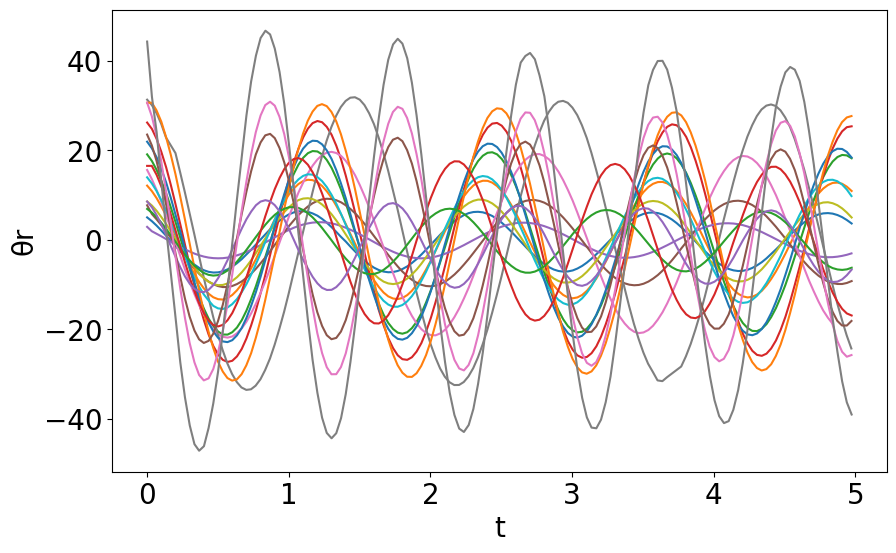

In [57]:
import os
import pandas as pd

# Adjust the input directory path to go up one level from the current directory
input_dir = os.path.join('..', 'datasets')

datasets = []

for folder in os.listdir(input_dir):
    folder_path = os.path.join(input_dir, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith('.csv'):
                # Add dataset to the list with subfolder and folder
                datasets.append(os.path.join(folder, file))

dataset_params = []

for i, dataset in enumerate(datasets):
    print(f"{i}: {dataset}")
    # Load a specific dataset into a DataFrame
    DATASET_CHOSEN = i
    data = pd.read_csv(os.path.join(input_dir, datasets[DATASET_CHOSEN]))
    L, dL = get_largo(data)
    data = format_pd(data)
    plot_data(data)
    #plt.show()
    tita0, amplitud, T, frecuencia, sigma_tita0, sigma_amplitud, sigma_T, sigma_frecuencia = get_all_params(data)
    dicc = gen_dicc(data)
    dataset_params.append((L, tita0, amplitud, T, frecuencia, (23 if dataset.split()[0] == "plata" else 72), dL, sigma_tita0, sigma_amplitud, sigma_T, sigma_frecuencia))
    #print(f"θ0: {tita0}, A: {amplitud}, T: {T}, f: {frecuencia}")
    print(dataset_params[-1])
    #plot_approximation(data, tita0=tita0, amplitud=amplitud, frecuencia=frecuencia, periodo=T)
    #plt.show()


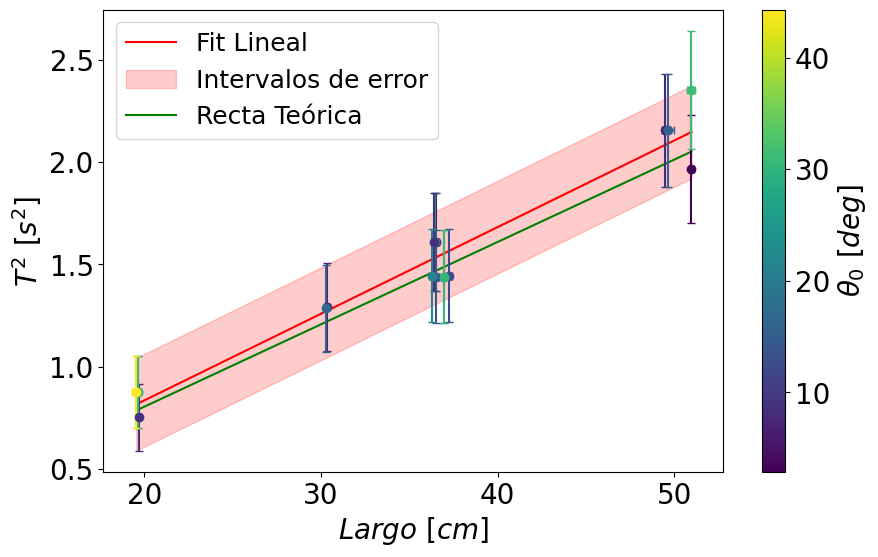

Estimated gravity (g): 9.321777711572654 ± 0.5194169816907779 m/s^2


C:\Users\Fran\AppData\Local\Temp\ipykernel_16064\3787475055.py:100: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


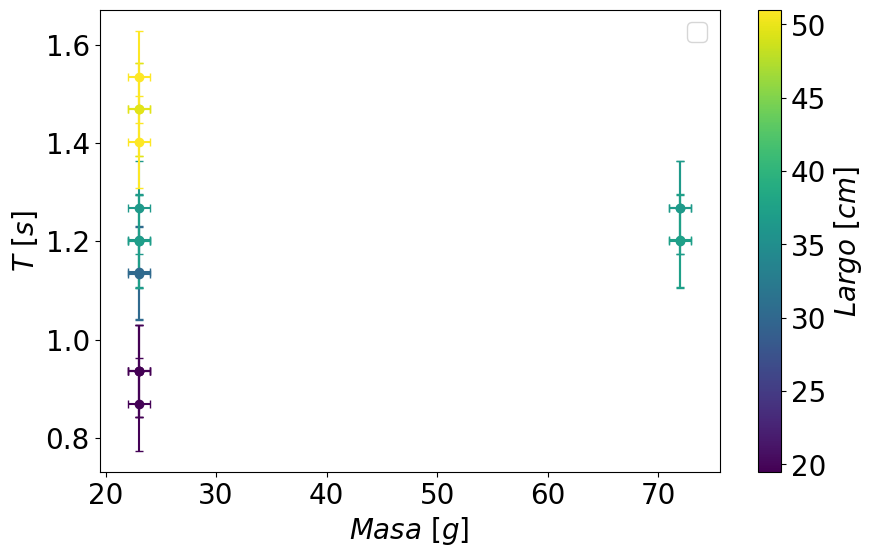

C:\Users\Fran\AppData\Local\Temp\ipykernel_16064\3787475055.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


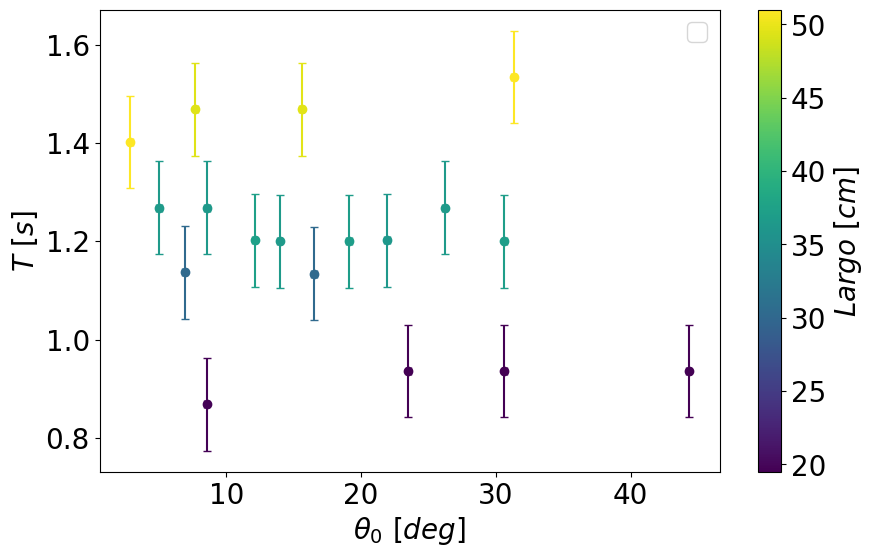

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def graph_params(dataset_params):
    # Crear un DataFrame con los datos
    df = pd.DataFrame(dataset_params, columns=["L", "tita0", "A", "T", "f", "m", "dL",
                                               "sigma_tita0", "sigma_A", "sigma_T", "sigma_f"])

    # Ajustar un modelo de regresión lineal para estimar la gravedad
    reg = LinearRegression().fit(df["L"].values.reshape(-1, 1), (df["T"]**2).values.reshape(-1, 1))

    # Preparar el colormap basado en tita0
    norm = plt.Normalize(vmin=df["tita0"].min(), vmax=df["tita0"].max())
    cmap = plt.cm.viridis
    colors = cmap(norm(df["tita0"]))

    # Gráfico T^2 vs L con colormap dependiendo de tita0
    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    # Dibujar las bandas de error y los puntos con colores correspondientes
    for i in range(len(df)):
        xi = df["L"].iloc[i]
        yi = (df["T"]**2).iloc[i]
        xerr_i = df["dL"].iloc[i]
        yerr_i = (df["sigma_T"] * 2 * df["T"]).iloc[i]
        color = colors[i]

        # Dibujar barras de error
        ax.errorbar(xi, yi, xerr=xerr_i, yerr=yerr_i, fmt='o', color=color, ecolor=color,
                    capsize=3, zorder=1)

    # Dibujar la línea de ajuste lineal
    x = np.linspace(df["L"].min(), df["L"].max(), 100)
    y_fit = reg.predict(x.reshape(-1, 1))
    ax.plot(x, y_fit, color="red", label='Fit Lineal', zorder=0)

    # Calcular y dibujar el intervalo de error
    delta = 2 * df["sigma_T"].mean() * df["T"].mean()
    ax.fill_between(x, (y_fit - delta).flatten(), (y_fit + delta).flatten(),
                    color='red', alpha=0.2, label="Intervalos de error", zorder=0)

    # Dibujar la recta teórica
    g = 9.80665 * 100
    y_teorica = (4 * np.pi**2 / g) * x
    ax.plot(x, y_teorica, color="green", label='Recta Teórica', zorder=0)

    # Añadir la barra de color para tita0
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)  # Especificar el eje actual
    cbar.set_label(r'$\theta_0\ [deg]$')

    # Ajustes finales del gráfico
    plt.xlabel(r'$Largo\ [cm]$')
    plt.ylabel(r'$T^2\ [s^2]$')
    plt.legend()
    plt.show()

    # Estimar la gravedad (g) a partir de la pendiente (T^2 = (4 * pi^2 / g) * L)
    slope = reg.coef_[0][0]
    intercept = reg.intercept_[0]
    g_estimated = (4 * np.pi**2 / slope) / 100  # cm a m

    # Calcular la incertidumbre en la pendiente
    residuals = (df["T"]**2) - (slope * df["L"] + intercept)
    residual_sum_of_squares = np.sum(residuals**2)
    degrees_of_freedom = len(df["L"]) - 2
    standard_error = np.sqrt(residual_sum_of_squares / degrees_of_freedom)
    slope_uncertainty = standard_error / np.sqrt(np.sum((df["L"] - df["L"].mean())**2))

    # Propagar la incertidumbre a g
    g_uncertainty = g_estimated * (slope_uncertainty / slope)

    print(f"Estimated gravity (g): {g_estimated} ± {g_uncertainty} m/s^2")

    # T vs m con gradiente de color basado en L
    df["L"] = df["L"].round(1)
    filtered_df = df
    df_filtered = df[(df["L"] >= 36) & (df["L"] <= 38)].copy()

    unique_lengths = np.sort(filtered_df["L"].unique())  # Ordenar las longitudes únicas
    norm_L = plt.Normalize(filtered_df["L"].min(), filtered_df["L"].max())
    colors_L = plt.cm.viridis(norm_L(unique_lengths))

    plt.figure(figsize=(10, 6))
    ax = plt.gca()  # Obtener los ejes actuales
    for length, color in zip(unique_lengths, colors_L):
        subset = filtered_df[filtered_df["L"] == length]
        ax.errorbar(subset["m"], subset["T"], yerr=subset["sigma_T"], fmt='o',
                    color=color, xerr=1, capsize=3)

    plt.xlabel(r'$Masa\ [g]$')
    plt.ylabel(r'$T\ [s]$')
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm_L)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label=r'$Largo\ [cm]$')
    plt.legend()
    plt.show()

    # T vs tita0 con gradiente de color basado en L
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    for length, color in zip(unique_lengths, colors_L):
        subset = filtered_df[filtered_df["L"] == length]
        ax.errorbar(subset["tita0"], subset["T"], yerr=subset["sigma_T"], fmt='o',
                    color=color, xerr=0.2, capsize=3)

    plt.xlabel(r'$\theta_0\ [deg]$')
    plt.ylabel(r'$T\ [s]$')
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm_L)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label=r'$Largo\ [cm]$')
    plt.legend()
    plt.show()

plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.labelsize": 20,
    "axes.titlesize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    
    "legend.fontsize": 18})



# Supongamos que dataset_params ya está definido y contiene los datos
graph_params(dataset_params)


In [59]:
print(dataset_params)

[(np.float64(36.53232342007435), np.float64(5.013), 6.848, np.float64(1.2679999999999996), np.float64(0.7886435331230287), 72, np.float64(0.11827758876940708), 1.0178492952302998, np.float64(0.7197281388832932), np.float64(0.09428090415820634), np.float64(0.05863882126290341)), (np.float64(37.2618313253012), np.float64(12.11), 13.379999999999999, np.float64(1.202), np.float64(0.831946755407654), 72, np.float64(0.15354595734279355), 1.0172934002130114, np.float64(0.7193350617469407), np.float64(0.09428090415820634), np.float64(0.06525515167331093)), (np.float64(36.93247216035635), np.float64(19.09), 20.5, np.float64(1.2000000000000002), np.float64(0.8333333333333333), 72, np.float64(0.15051864714965513), 1.0175415608283513, np.float64(0.7195105378008712), np.float64(0.09428090415820634), np.float64(0.06547285010986549)), (np.float64(36.45239837398374), np.float64(26.2), 26.91, np.float64(1.2680000000000007), np.float64(0.7886435331230279), 72, np.float64(0.19381594381286704), 1.01788310

0      5.013
1     12.110
2     19.090
3     26.200
8      8.562
9     13.960
10    21.920
11    30.630
Name: tita0, dtype: float64


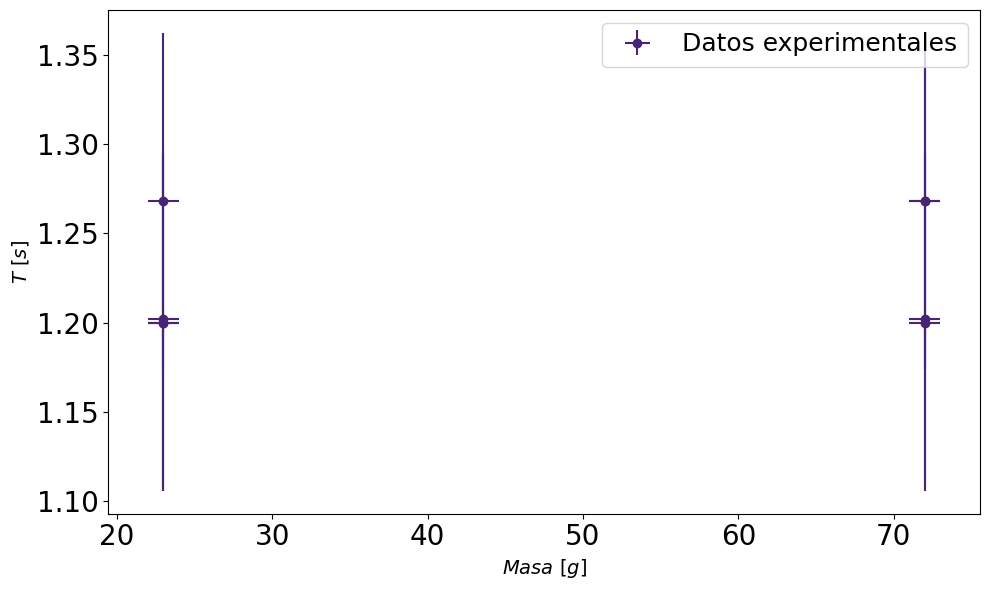

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def graph_params(dataset_params):
    # Definir los colores proporcionados
    colors = {
        'purple': (0.282623, 0.140926, 0.457517, 1.0),
        'blue':   (0.206756, 0.371758, 0.553117, 1.0),
        'green':  (0.127568, 0.566949, 0.550556, 1.0),
        'yellow': (0.741388, 0.873449, 0.149561, 1.0)
    }

    # Crear un DataFrame con los datos
    df = pd.DataFrame(dataset_params, columns=["L", "tita0", "A", "T", "f", "m", "dL", "sigma_tita0", "sigma_A", "sigma_T", "sigma_f"])

    # Filtrar los datos para las longitudes entre 36 y 38 cm
    df_filtered = df[(df["L"] >= 36) & (df["L"] <= 38)].copy()

    # Convertir longitud a cm
    df_filtered["L_m"] = df_filtered["L"] / 100

    # Calcular el período teórico para cada longitud
    g = 9.81  # Aceleración de la gravedad en m/s^2
    df_filtered["T_teorico"] = 2 * np.pi * np.sqrt(df_filtered["L_m"] / g)

    print(df_filtered["tita0"])

    # Gráfico T vs m con los colores especificados
    plt.figure(figsize=(10, 6))
    ax = plt.gca()  # Obtener el eje actual

    # Graficar la comparación entre diferentes masas para longitudes entre 36 y 38 cm
    ax.errorbar(df_filtered["m"], df_filtered["T"], yerr=df_filtered["sigma_T"], fmt='o', color=colors['purple'], xerr=1, label='Datos experimentales')

    # Añadir leyenda
    ax.legend(title_fontsize='14', fontsize=18, loc='upper right')

    # Ajustes estéticos para mejorar la presentación del gráfico
    plt.xlabel(r'$Masa\ [g]$', fontsize=14)
    plt.ylabel(r'$T\ [s]$', fontsize=14)
    plt.tight_layout()  # Asegurarse de que los elementos del gráfico no se superpongan

    plt.show()

# Supongamos que dataset_params ya está definido y contiene los datos
graph_params(dataset_params)

In [61]:

def hex_to_rgba(hex_color, alpha=1.0):
    hex_color = hex_color.lstrip('#')
    lv = len(hex_color)
    return tuple(int(hex_color[i:i + lv // 3], 16) / 255.0 for i in range(0, lv, lv // 3)) + (alpha,)

colors = [hex_to_rgba('#4D88FF', 0.7), hex_to_rgba('#CC3333', 0.7)]  # Lighter blue and darker red with some transparency

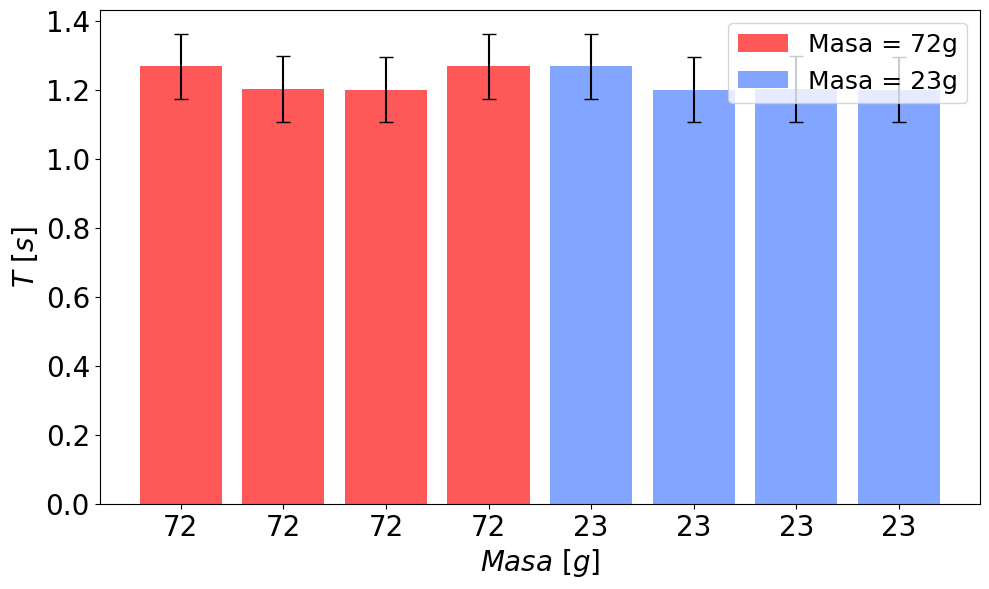

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Función para convertir un color en formato hexadecimal a RGBA
def hex_to_rgba(hex_color, alpha=1.0):
    h = hex_color.lstrip('#')
    return tuple(int(h[i:i+2], 16) / 255.0 for i in (0, 2, 4)) + (alpha,)

# Colores definidos para cada grupo de masa
color_72g = hex_to_rgba('#ff1111', 0.7)
color_other = (0.3, 0.5, 1, 0.7)

# Función para procesar los datos, filtrar y calcular
def process_data(dataset_params):
    df = pd.DataFrame(dataset_params, columns=["L", "tita0", "A", "T", "f", "m", "dL", "sigma_tita0", "sigma_A", "sigma_T", "sigma_f"])
    df_filtered = df[(df["L"] >= 36) & (df["L"] <= 38)].copy()
    df_filtered["L_m"] = df_filtered["L"] / 100
    g = 9.81
    df_filtered["T_teorico"] = 2 * np.pi * np.sqrt(df_filtered["L_m"] / g)
    return df_filtered

# Función para graficar los datos procesados en un gráfico de barras con barras de error
def plot_bar_data(df_filtered):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Posiciones de las barras
    x_positions = np.arange(len(df_filtered["m"]))
    
    # Separar los datos según el valor de la masa
    mask_72g = df_filtered["m"] == 72
    mask_other = ~mask_72g

    # Crear las barras con colores diferenciados y etiquetas para la leyenda
    ax.bar(x_positions[mask_72g], df_filtered["T"][mask_72g], color=color_72g, yerr=df_filtered["sigma_T"][mask_72g], capsize=5, label='Masa = 72g')
    ax.bar(x_positions[mask_other], df_filtered["T"][mask_other], color=color_other, yerr=df_filtered["sigma_T"][mask_other], capsize=5, label='Masa = 23g')
    
    # Etiquetas y formato
    ax.set_xticks(x_positions)
    ax.set_xticklabels(df_filtered["m"].astype(str), rotation=0, fontsize=12)
    ax.set_xlabel(r'$Masa\ [g]$', fontsize=20)
    ax.set_ylabel(r'$T\ [s]$', fontsize=20)

    # Aumentar tamaño de fuente en ejes
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

    # Añadir la leyenda y mostrar
    ax.legend(title_fontsize='14', fontsize=18, loc='upper right')
    plt.tight_layout()
    plt.show()

# Función principal que coordina el procesamiento de datos y la graficación
def graph_params(dataset_params):
    df_filtered = process_data(dataset_params)
    plot_bar_data(df_filtered)


plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.labelsize": 20,
    "axes.titlesize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    
    "legend.fontsize": 18})




# Supongamos que dataset_params ya está definido y contiene los datos
graph_params(dataset_params)


{'purple': (np.float64(0.282623), np.float64(0.140926), np.float64(0.457517), np.float64(1.0)), 'blue': (np.float64(0.206756), np.float64(0.371758), np.float64(0.553117), np.float64(1.0)), 'green': (np.float64(0.127568), np.float64(0.566949), np.float64(0.550556), np.float64(1.0)), 'yellow': (np.float64(0.741388), np.float64(0.873449), np.float64(0.149561), np.float64(1.0))}


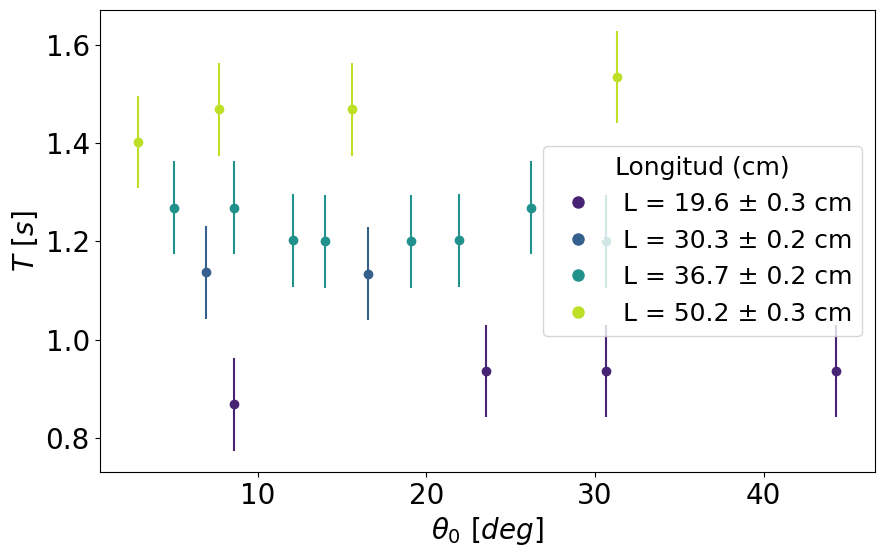

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def graph_params(dataset_params):
    # Crear un DataFrame con los datos
    df = pd.DataFrame(dataset_params, columns=["L", "tita0", "A", "T", "f", "m", "dL", "sigma_tita0", "sigma_A", "sigma_T", "sigma_f"])

    # Obtener colores discretos de la paleta viridis usando plt.get_cmap
    cmap = plt.get_cmap('viridis')
    colors_dict = {
        'purple': cmap(0.1),  # Violeta claro (L < 30 cm)
        'blue': cmap(0.3),    # Azul claro (30 cm ≤ L < 33 cm)
        'green': cmap(0.5),   # Verde claro (33 cm ≤ L < 45 cm)
        'yellow': cmap(0.9)   # Amarillo (L ≥ 45 cm)
    }

    # Asignar colores específicos según los rangos de longitud
    def get_color_for_length(length):
        if length < 30:
            return colors_dict['purple']
        elif 30 <= length < 33:
            return colors_dict['blue']
        elif 33 <= length < 45:
            return colors_dict['green']
        elif length >= 45:
            return colors_dict['yellow']

    # Gráfico T vs tita0 con color asignado según el rango de longitud
    plt.figure(figsize=(10, 6))
    ax = plt.gca()  # Obtener el eje actual

    # Agregar los puntos al gráfico
    for _, row in df.iterrows():
        color = get_color_for_length(row["L"])
        ax.errorbar(row["tita0"], row["T"], yerr=row["sigma_T"], fmt='o', color=color, xerr=0.2)

    # Añadir leyenda manualmente
    from matplotlib.lines import Line2D

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_dict['purple'], markersize=10, label='L = 19.6 ± 0.3 cm'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_dict['blue'], markersize=10, label='L = 30.3 ± 0.2 cm'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_dict['green'], markersize=10, label='L = 36.7 ± 0.2 cm'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_dict['yellow'], markersize=10, label='L = 50.2 ± 0.3 cm')
    ]

    print(colors_dict)

    ax.legend(handles=legend_elements, title='Longitud (cm)', title_fontsize='18',loc='center right')

    # Etiquetas de los ejes y mostrar el gráfico
    plt.xlabel(r'$\theta_0\ [deg]$')
    plt.ylabel(r'$T\ [s]$')
    plt.show()

# Supongamos que dataset_params ya está definido y contiene los datos
graph_params(dataset_params)
